In [58]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import numpy as np
import pandas as pd
import pickle
import tflscripts
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns; sns.set()

configuration = tflscripts.read_configuration()

In [59]:
df_results = pd.read_pickle('results_with_accuracy_classified_s5.p')
df_results = df_results.loc[df_results.f1_wt >= 0.75]
df_results = df_results.loc[df_results.specificity_5 >= 0.95]
df_results = df_results.loc[(df_results.predictions > 0)]
df_results = df_results.loc[df_results.type_of_transfer != 'No transfer']

In [60]:
def key_for_test(source_dataset,
                    source_device,
                    target_dataset,
                    target_device,
                    label,
                    features,
                    classifier):
    return source_dataset + source_device + target_dataset + target_device + \
        label + features + classifier

def key_for_result_row(row):
    return key_for_test(source_dataset=row['source_dataset'],
                       source_device=row['source_device_id'],
                       target_dataset=row['target_dataset'],
                       target_device=row['target_device_id'],
                       label=row['label'],
                       features=row['features'],
                       classifier=row['classifier'])

def key_for_test_result(result):
    return key_for_test(source_dataset=result.source_dataset,
                       source_device=result.source_device,
                       target_dataset=result.target_dataset,
                       target_device=result.target_device,
                       label=result.label_name(),
                       features=result.features,
                       classifier=result.classifier)

def test_results_for_df(df_results):
    wanted_test_results = {}
    for i, row in df_results.iterrows():
        key = key_for_result_row(row)
        wanted_test_results[key] = i

    found_test_results = {}
    for dataset in df_results.source_dataset.unique():
        for device in df_results.source_device_id.unique():
            test_set = tflscripts.TestSet(name='_'.join([dataset, device]))
            if test_set.exists():
                for result in test_set.get_results():
                    key = key_for_test_result(result)
                    if key in wanted_test_results:
                        result_row_id = wanted_test_results[key]
                        found_test_results[result_row_id] = result

    return found_test_results

def filter_results_by_accuracy(case_results, accuracy_column):
    label_models = {}
    for i, row_result in case_results.iterrows():
        label = row_result['label']
        if label in label_models:
            other_row_result = case_results.loc[case_results.index == label_models[label]].iloc[0]
            if other_row_result[accuracy_column] < row_result[accuracy_column]:
                label_models[label] = i
        else:
            label_models[label] = i

    result_ids = list(label_models.values())
    return result_ids

def majority_vote(row):
    value_counts = row.value_counts()
    value_counts = value_counts[value_counts.index != -1]
    if len(value_counts) == 0:
        return -1
    return value_counts.idxmax()

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    non_normalized = cm
    if normalize:
        cm = np.nan_to_num(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2))

#     print(cm)

    thresh = non_normalized.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if non_normalized[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [62]:
def test_transfer(source_room, source_placement, target_room, target_placement, df, source_device_type='Mite', target_device_type='Mite', across_device_transfer=False):
    df = df.loc[(df.source_room == source_room) & (df.source_placement == source_placement)]
    df = df.loc[(df.target_room == target_room) & (df.target_placement == target_placement)]
    if source_device_type is not None:
        df = df.loc[(df.source_device_type == source_device_type)]
    if source_device_type is not None:
        df = df.loc[(df.target_device_type == target_device_type)]
    if across_device_transfer:
        df = df.loc[(df.source_device_type != df.target_device_type)]

    df = df.loc[df.predictions > 0]
    df = df.sort_values(by=['predictions', 'specificity'], ascending=False)
    df = df.drop_duplicates(['label'], keep='first')

    test_results_h = test_results_for_df(df)
    test_results = list(test_results_h.values())
    all_predictions = []

    for test_result in test_results:
        result_df = pd.DataFrame({'predicted': test_result.predicted, 'actual': test_result.actual_with_all_labels})
        missed_df = result_df.loc[result_df.actual == test_result.label]

        total_len = len(result_df.loc[(result_df.predicted != -1) | (result_df.actual == test_result.label)])
        result_df = result_df.loc[result_df.predicted != -1]
        predictions = result_df.actual.value_counts() / total_len
        predictions['Missed'] = len(missed_df.loc[missed_df.predicted == -1]) / total_len
        all_predictions.append(predictions)

    predictions_df = pd.DataFrame(all_predictions)
    predictions_df.index = [r.label for r in test_results]
    predictions_df = predictions_df.fillna(0.0)
    predictions_df = predictions_df.sort_index()
    predictions_df = predictions_df[predictions_df.index.tolist() + ['Missed']]

    acts = configuration['activities']
    predictions_df.columns = [i if i == 'Missed' else acts[i] for i in predictions_df.columns]
    predictions_df.index = [i if i == 'Missed' else acts[i] for i in predictions_df.index]

    return predictions_df

def get_transferred_models(source_room, source_placement, target_room, target_placement, df, source_device_type='Mite', target_device_type='Mite', across_device_transfer=False):
    df = df.loc[(df.source_room == source_room) & (df.source_placement == source_placement)]
    df = df.loc[(df.target_room == target_room) & (df.target_placement == target_placement)]
    if source_device_type is not None:
        df = df.loc[(df.source_device_type == source_device_type)]
    if source_device_type is not None:
        df = df.loc[(df.target_device_type == target_device_type)]
    if across_device_transfer:
        df = df.loc[(df.source_device_type != df.target_device_type)]

    df = df.loc[df.predictions > 0]
    df = df.sort_values(by=['predictions', 'specificity'], ascending=False)
    df = df.drop_duplicates(['label'], keep='first')

    return df

def get_all_transferred_models(source_room, source_placement, target_room, target_placement, df, source_device_type='Mite', target_device_type='Mite', across_device_transfer=False):
    df = df.loc[(df.source_room == source_room) & (df.source_placement == source_placement)]
    df = df.loc[(df.target_room == target_room) & (df.target_placement == target_placement)]
    if source_device_type is not None:
        df = df.loc[(df.source_device_type == source_device_type)]
    if source_device_type is not None:
        df = df.loc[(df.target_device_type == target_device_type)]
    if across_device_transfer:
        df = df.loc[(df.source_device_type != df.target_device_type)]

    df = df.loc[df.predictions > 0]

    return df

In [63]:
# synergy_coffee_to_sink = test_transfer(
#     source_room='synergy',
#     source_placement='Coffee',
#     target_room='synergy',
#     target_placement='Sink',
#     df=df_results
# )

synergy_table_to_sink = test_transfer(
    source_room='synergy',
    source_placement='Table',
    target_room='synergy',
    target_placement='Sink',
    df=df_results
)

# scott_right_to_left = test_transfer(
#     source_room='scott',
#     source_placement='Right',
#     target_room='scott',
#     target_placement='Left',
#     df=df_results
# )

# scott_pantry_to_left = test_transfer(
#     source_room='scott',
#     source_placement='Pantry',
#     target_room='scott',
#     target_placement='Left',
#     df=df_results
# )

scott_right_to_synergy_coffee = test_transfer(
    source_room='scott',
    source_placement='Right',
    target_room='synergy',
    target_placement='Coffee',
    df=df_results
)

In [64]:
# synergy_coffee_xdk_to_mite = test_transfer(
#     source_room='synergy',
#     source_placement='Coffee',
#     target_room='synergy',
#     target_placement='Coffee',
#     source_device_type='XDK',
#     target_device_type='Mite',
#     df=df_results
# )

# synergy_coffee_mite_to_xdk = test_transfer(
#     source_room='synergy',
#     source_placement='Coffee',
#     target_room='synergy',
#     target_placement='Coffee',
#     source_device_type='Mite',
#     target_device_type='XDK',
#     df=df_results
# )

# synergy_sink_xdk_to_mite = test_transfer(
#     source_room='synergy',
#     source_placement='Sink',
#     target_room='synergy',
#     target_placement='Sink',
#     source_device_type='XDK',
#     target_device_type='Mite',
#     df=df_results
# )

In [65]:
synergy_coffee_any_to_mite = test_transfer(
    source_room='synergy',
    source_placement='Coffee',
    target_room='synergy',
    target_placement='Coffee',
    source_device_type=None,
    target_device_type='Mite',
    across_device_transfer=True,
    df=df_results
)

In [66]:
synergy_coffee_mites = test_transfer(
    source_room='synergy',
    source_placement='Coffee',
    target_room='synergy',
    target_placement='Coffee',
    df=df_results
)

In [67]:
# synergy_sink_mites = test_transfer(
#     source_room='synergy',
#     source_placement='Sink',
#     target_room='synergy',
#     target_placement='Sink',
#     df=df_results
# )

In [68]:
# scott_left_to_synergy_sink = test_transfer(
#     source_room='scott',
#     source_placement='Right',
#     target_room='synergy',
#     target_placement='Sink',
#     df=df_results
# )

# synergy_coffee_to_scott_right = test_transfer(
#     source_room='synergy',
#     source_placement='Coffee',
#     target_room='scott',
#     target_placement='Right',
#     df=df_results
# )

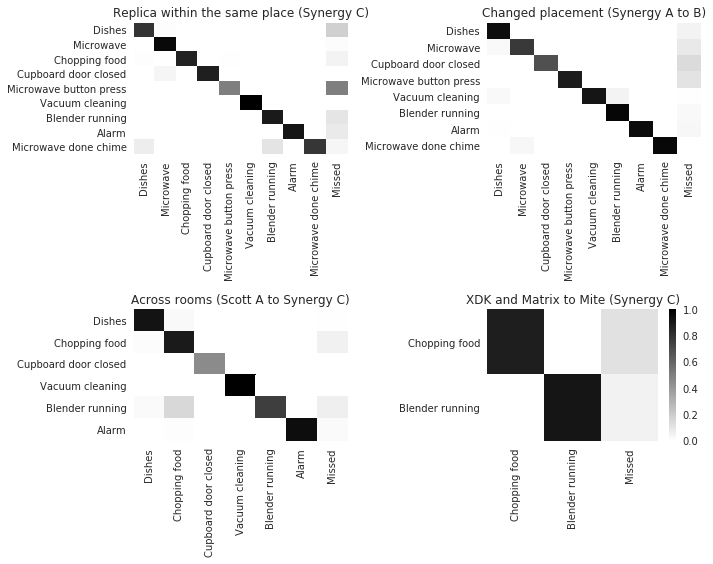

In [77]:
plt.rcParams["figure.figsize"] = (10, 8)

f, axes = plt.subplots(2, 2, sharex=False, sharey=False)

sns.heatmap(synergy_coffee_mites, cmap='binary', ax=axes[0][0], cbar=None, vmin=0, vmax=1)
matplotlib.pyplot.sca(axes[0][0])
plt.title('Replica within the same place (Synergy C)')
plt.tight_layout()

sns.heatmap(synergy_table_to_sink, cmap='binary', ax=axes[0][1], cbar=None, vmin=0, vmax=1)
matplotlib.pyplot.sca(axes[0][1])
plt.title('Changed placement (Synergy A to B)')

sns.heatmap(scott_right_to_synergy_coffee, cmap='binary', ax=axes[1][0], cbar=None, vmin=0, vmax=1)
matplotlib.pyplot.sca(axes[1][0])
plt.title('Across rooms (Scott A to Synergy C)')

sns.heatmap(synergy_coffee_any_to_mite, cmap='binary', ax=axes[1][1], vmin=0, vmax=1)
matplotlib.pyplot.sca(axes[1][1])
plt.title('XDK and Matrix to Mite (Synergy C)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()

plt.savefig('../plots/predictions_per_transfer_examples.pdf')
plt.show()

In [72]:
def evaluate_results(label, models):
    print(label, round(models.f1.median(), 2), round(models.f1.std(), 2))
    print(len(models.loc[models.f1 <= 0.75]))
    print()

models = get_transferred_models(
    source_room='synergy',
    source_placement='Coffee',
    target_room='synergy',
    target_placement='Coffee',
    source_device_type=None,
    target_device_type='Mite',
    across_device_transfer=True,
    df=df_results
)

evaluate_results('sensor boards', models)

models = get_transferred_models(
    source_room='synergy',
    source_placement='Coffee',
    target_room='synergy',
    target_placement='Coffee',
    df=df_results
)
evaluate_results('replica', models)

models = get_transferred_models(
    source_room='scott',
    source_placement='Right',
    target_room='synergy',
    target_placement='Coffee',
    df=df_results
)
evaluate_results('spaces', models)

models = get_transferred_models(
    source_room='synergy',
    source_placement='Table',
    target_room='synergy',
    target_placement='Sink',
    df=df_results
)
evaluate_results('placement', models)

sensor boards 0.95 0.01
0

replica 0.93 0.1
1

spaces 0.95 0.14
1

placement 0.97 0.06
0



In [71]:
models = get_all_transferred_models(
    source_room='synergy',
    source_placement='Coffee',
    target_room='synergy',
    target_placement='Coffee',
    df=df_results
)

models.loc[models.label == 'Soap dispensed'].features_name

Series([], Name: features_name, dtype: object)

In [28]:
df_results.loc[df_results.type_of_transfer == 'Different device in same place'][['source_placement', 'label', 'source_device_type', 'target_device_type', 'source_room']]

,source_placement,label,source_device_type,target_device_type,source_room
2508,Sink,Dishes,Mite,XDK,robotics
10075,Sink,Microwave,XDK,Matrix,robotics
10165,Sink,Microwave,XDK,Matrix,robotics
58038,Left,Dishes,Mite,XDK,scott
63348,Left,Dishes,XDK,Mite,scott
129021,Coffee,Chopping food,Mite,XDK,synergy
130573,Sink,Dishes,Mite,XDK,synergy
130603,Sink,Dishes,Mite,XDK,synergy
130633,Sink,Dishes,Mite,XDK,synergy
134589,Coffee,Chopping food,XDK,Mite,synergy
